In [1]:
from math import *
from networkx import *
import random
from copy import deepcopy
import os, sys
import time
from sympy.solvers import solve
from sympy import Symbol
from scipy.optimize import curve_fit
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from p_tqdm import p_map
from natsort import natsorted
import numpy as np
from multiprocessing import Pool
import collections
import powerlaw
import community as cm

In [2]:
def MEMB(G,rb,cycle=0):
	"""
	It returns a dictionary with {box_id:subgraph_generated_by_the_nodes_in_this_box}
	The box_id is the center of the box.
	cycle: Ignore this parameter. Use the default cycle=0.
	"""
	adj = G.adj
	number_of_nodes = G.number_of_nodes()
	covered_nodes = set()
	center_nodes = set()
	non_center_nodes = G.nodes()
	center_node_found = 0
	boxes={} #this will be "box_id:[nodes in box]"
	central_distance_of_node = {} #"node:central_distance"
	node_box_id = {} #"node:box_id"
	nodes_sorted_by_central_distance={} #Dict with {central_distance:[nodes]}
	excluded_mass_of_non_centers_rb = {} #This contains [(node:excluded_mass)] for rb
	excluded_mass_of_non_centers_rb2 = {} #This contains [(node:excluded_mass)] for rb+1
	rb2 = rb + 1
	for node in non_center_nodes:
		#if node in [5000,10000,20000,30000]: print "node", node
		level=0                  # the current level
		nextlevel={node:1}       # list of nodes to check at next level
		paths_rb=None
		paths_rb2={node:[node]} # paths dictionary  (paths to key from source)
		while nextlevel:
			paths_rb = deepcopy(paths_rb2)
			thislevel=nextlevel
			nextlevel={}
			for v in thislevel:
				for w in G.neighbors(v):
					if not w in paths_rb2:
						paths_rb2[w]=paths_rb2[v]+[w]
						nextlevel[w]=1
			level=level+1
			if (rb2 <= level):  break
		excluded_mass_of_node = len(paths_rb2)
		try:
			excluded_mass_of_non_centers_rb2[excluded_mass_of_node].append(node)
		except KeyError:
			excluded_mass_of_non_centers_rb2[excluded_mass_of_node] = [node]
		excluded_mass_of_node = len(paths_rb)
		try:
			excluded_mass_of_non_centers_rb[excluded_mass_of_node].append(node)
		except KeyError:
			excluded_mass_of_non_centers_rb[excluded_mass_of_node] = [node]
	maximum_excluded_mass = 0
	nodes_with_maximum_excluded_mass=[]
	new_covered_nodes = {}
	center_node_and_mass = []
	cycle_index = 0
	while len(covered_nodes) < number_of_nodes:
		#print len(covered_nodes),number_of_nodes
		cycle_index += 1
		if cycle_index == cycle:
			rb2 = rb+1
			cycle_index = 0
		else:
			rb2 = rb
		while 1:
			if rb2 == rb+1:
				#t1=time.time()
				while 1:
					maximum_key = max(excluded_mass_of_non_centers_rb2.keys())
					node = random.choice(excluded_mass_of_non_centers_rb2[maximum_key])
					if node in center_nodes:
						excluded_mass_of_non_centers_rb2[maximum_key].remove(node)
						if not excluded_mass_of_non_centers_rb2[maximum_key]: del excluded_mass_of_non_centers_rb2[maximum_key]
					else:
						break
				nodes_visited = {}
				bfs = single_source_shortest_path(G,node,cutoff=rb2)
				for i in bfs:
					nodes_visited[i] = len(bfs[i])-1
				excluded_mass_of_node = len(set(nodes_visited.keys()).difference(covered_nodes))
				if excluded_mass_of_node == maximum_key:
					center_node_and_mass = (node,maximum_key)
					excluded_mass_of_non_centers_rb2[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb2[maximum_key]: del excluded_mass_of_non_centers_rb2[maximum_key]
					new_covered_nodes = nodes_visited
					break
				else:
					excluded_mass_of_non_centers_rb2[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb2[maximum_key]: del excluded_mass_of_non_centers_rb2[maximum_key]
					try:
						excluded_mass_of_non_centers_rb2[excluded_mass_of_node].append(node)
					except KeyError:
						excluded_mass_of_non_centers_rb2[excluded_mass_of_node] = [node]
				#print "time", time.time()-t1
			else:
				#t1=time.time()
				while 1:
					maximum_key = max(excluded_mass_of_non_centers_rb.keys())
					node = random.choice(excluded_mass_of_non_centers_rb[maximum_key])
					if node in center_nodes:
						excluded_mass_of_non_centers_rb[maximum_key].remove(node)
						if not excluded_mass_of_non_centers_rb[maximum_key]: del excluded_mass_of_non_centers_rb[maximum_key]
					else:
						break
				nodes_visited = {}
				bfs = single_source_shortest_path(G,node,cutoff=rb)
				for i in bfs:
					nodes_visited[i] = len(bfs[i])-1
				excluded_mass_of_node = len(set(nodes_visited.keys()).difference(covered_nodes))
				if excluded_mass_of_node == maximum_key:
					center_node_and_mass = (node,maximum_key)
					excluded_mass_of_non_centers_rb[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb[maximum_key]: del excluded_mass_of_non_centers_rb[maximum_key]
					new_covered_nodes = nodes_visited
					break
				else:
					excluded_mass_of_non_centers_rb[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb[maximum_key]: del excluded_mass_of_non_centers_rb[maximum_key]
					try:
						excluded_mass_of_non_centers_rb[excluded_mass_of_node].append(node)
					except KeyError:
						excluded_mass_of_non_centers_rb[excluded_mass_of_node] = [node]
				#print "time", time.time()-t1

		center_node_found = center_node_and_mass[0]
		boxes[center_node_found] = [center_node_found]
		node_box_id[center_node_found] = center_node_found
		non_center_nodes = list(non_center_nodes)
		non_center_nodes.remove(center_node_found)
		center_nodes.add(center_node_found)

		covered_nodes = covered_nodes.union(set(new_covered_nodes.keys()))
		#print len(covered_nodes)
		for i in new_covered_nodes:

			try:
				if central_distance_of_node[i] > new_covered_nodes[i]:
					nodes_sorted_by_central_distance[central_distance_of_node[i]].remove(i)
					if not nodes_sorted_by_central_distance[central_distance_of_node[i]]:
						del nodes_sorted_by_central_distance[central_distance_of_node[i]]
					try:
						nodes_sorted_by_central_distance[new_covered_nodes[i]].append(i)
					except KeyError:
						nodes_sorted_by_central_distance[new_covered_nodes[i]] = [i]
					central_distance_of_node[i] = new_covered_nodes[i]
			except KeyError:
				central_distance_of_node[i] = new_covered_nodes[i]
				try:
					nodes_sorted_by_central_distance[new_covered_nodes[i]].append(i)
				except:
					nodes_sorted_by_central_distance[new_covered_nodes[i]] = [i]

	max_distance = max(nodes_sorted_by_central_distance.keys())
	for i in range(1,max_distance+1):
		for j in nodes_sorted_by_central_distance[i]:
			targets = list(set(list(adj[j])).intersection(set(nodes_sorted_by_central_distance[i-1])))
			node_box_id[j] = node_box_id[random.choice(targets)]
			boxes[node_box_id[j]].append(j)
	boxes_subgraphs={}
	for i in boxes:
		boxes_subgraphs[i] = subgraph(G,boxes[i])

	return boxes_subgraphs

In [22]:
# g = nx.read_gml('power.gml', label='id')
# g = nx.read_graphml('time_graphs/0/2000.graphml')
# g = nx.read_graphml('0.graphml')
# g = nx.read_edgelist('real_graphs/facebook_combined.txt')
# g = fractal_model(3,5,2,0)
# g = nx.erdos_renyi_graph(1000, 0.05)
g = nx.barabasi_albert_graph(1500, 6)
print(len(list(nx.connected_components(g))))
print(g.number_of_nodes(), g.number_of_edges())

1
1500 8964


In [23]:
print(nx.diameter(g))

5


In [26]:
max_l = 4

In [27]:
avgs = []
subgraphs = []

for l in tqdm_notebook(range(max_l)):
    boxes_subgraphs = MEMB(g,l)
    print(l, len(boxes_subgraphs), sum([g.number_of_nodes() for g in boxes_subgraphs.values()]) / len(boxes_subgraphs))
    avgs.append(len(boxes_subgraphs))
    subgraphs.append(boxes_subgraphs)

0 1500 1.0
1 122 12.295081967213115
2 7 214.28571428571428
3 1 1500.0



[1.00000000e+00 8.13333333e-02 4.66666667e-03 6.66666667e-04]
[3.71329446]


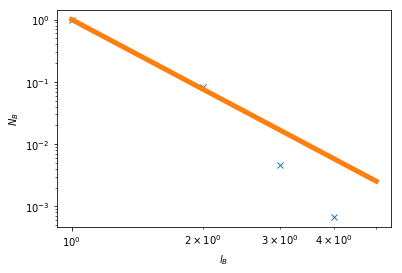

In [36]:
# fig = plt.figure()
# ax = plt.gca()
# ax.set_yscale('log')
# ax.scatter([1, 2, 3, 4, 5], [x / ref.number_of_nodes() for x in avgs])
# # ax.set_yscale('log')

def hausdorff(lb, db):
    return lb**-db

x = np.arange(1, max_l + 1)
# y = np.array(avgs)
y = np.array([x / g.number_of_nodes() for x in avgs])
# y = np.array([ref.number_of_nodes() / x for x in avgs])
print(y)

popt = curve_fit(hausdorff, x, y)[0]
print(popt)
db = popt[0]

plt.xlabel('$l_B$')
plt.ylabel('$N_B$')
plt.xscale('log')
plt.yscale('log')
xx = np.linspace(1, max_l + 1, 100)
yy = [hausdorff(x, popt) for x in xx]
plt.plot(x, y, 'x')
plt.plot(xx, yy, lw=5)

72
[ 2.71531476 32.39976503]


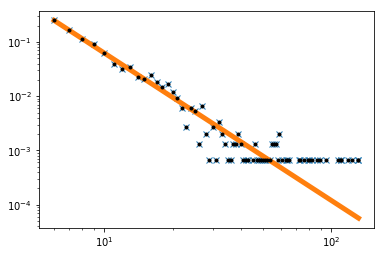

In [29]:
degree_sequence = [d for (n, d) in g.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
tot = sum(cnt)
per = [c / tot for c in cnt]

ts = sorted([(deg[i], per[i]) for i in range(len(per))])
deg = [t[0] for t in ts]
per = [t[1] for t in ts]

def deg_curve(lb, gamma, a):
    return a * lb**-gamma

x = deg[6:]
x = deg
y = per[6:]
y = per

print(len(x))

popt = curve_fit(deg_curve, x, y)[0]
print(popt)
gamma = popt[0]

plt.xscale('log')
plt.yscale('log')
plt.plot(deg, per, 'x')
xx = np.linspace(min(deg), max(deg), 100)
yy = [deg_curve(x, *popt) for x in xx]
plt.plot(xx, yy, lw=5)
plt.plot(x, y, '.', c='black')
plt.show()


In [30]:
def deg_plot(G):

    degree_sequence = [d for (n, d) in G.degree()]
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    tot = sum(cnt)
    per = [c / tot for c in cnt]

    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(deg, per)
    plt.show()

length scale:  1 num nodes:  1500 num edges:  8964
======== [1.54006169] ========


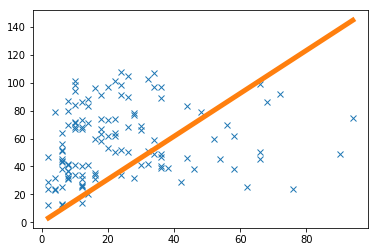

length scale:  2 num nodes:  1500 num edges:  8964
======== [0.00805295] ========


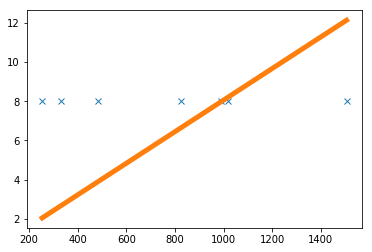

In [31]:
# ref = fractal_model(5,2,2,0)
ref = g
sbs = []

def scaler(x, y):
    return y * x

for l in tqdm_notebook(np.arange(1, max_l - 1)):
#     g = nx.read_graphml('time_graphs/0/4990.graphml')
    ref = g
    print("length scale: ", l, "num nodes: ", ref.number_of_nodes(), "num edges: ", ref.number_of_edges())
    boxes_subgraphs = list(subgraphs[l].values())
#     ks = [sorted(box.degree, key=lambda x: x[1], reverse=True)[0][1] for box in boxes_subgraphs]
    ks = [box.number_of_edges() / 0.5 for box in boxes_subgraphs]
    node_dict = {}
    for idx, box in enumerate(boxes_subgraphs):
        for node in box.nodes:
            node_dict[node] = str(idx)
    edges = []
    for edge in ref.edges:
        edges.append(tuple(sorted([node_dict[edge[0]], node_dict[edge[1]]])))

    edges = list(set(edges))
    ref = nx.Graph()
    ref.add_edges_from(edges)
    k_primes = ref.degree()
    k_primes = [k[1] for k in k_primes]

    vals = [(ks[i], k_primes[i]) for i in range(len(ks))]
    vals = sorted(vals)
    ks = [v[0] for v in vals]
    k_primes = [v[1] for v in vals]
    
    popt = curve_fit(scaler, ks, k_primes)[0]
    print("========", popt, "========")
    sbs.append(popt)

    plt.plot(ks, k_primes, 'x')
    xx = np.linspace(ks[0], ks[-1], 100)
    yy = [scaler(x, popt) for x in xx]
    plt.plot(xx, yy, lw=5)
    
    plt.show()

[6.95626629]


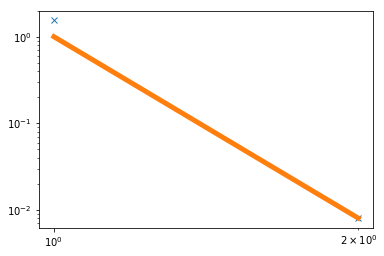

In [32]:
def deg_curve(lb, gamma):
    return lb**-gamma

x = np.arange(1, len(sbs) + 1)
y = [s[0] for s in sbs]

popt = curve_fit(deg_curve, x, y)[0]
print(popt)
dk = popt[0]

plt.xscale('log')
plt.yscale('log')
plt.plot(x, y, 'x')
xx = np.linspace(x[0], x[-1], 100)
yy = [deg_curve(x, popt) for x in xx]
plt.plot(xx, yy, lw=5)
plt.show()

In [33]:
1 + db / dk

1.5338056803535278

In [34]:
gamma

2.715314761093118